<a href="https://colab.research.google.com/github/ResponsiveWebApps/Twitter-Sentiment-Analysis-for-Stocks/blob/main/Twitter_Sentiment_Analysis_for_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
# Pip installs
# NLTK: Natural Language tool kit
!pip install nltk

# Gensim
!pip install gensim

In [3]:
# Mount Google drive and data
from google.colab import drive
drive.mount('/content/drive')

# load the stock news data
stock_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/stock_sentiment.csv")

Mounted at /content/drive


**Dataset info**

In [4]:
stock_df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [6]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [5]:
stock_df.isnull().sum()

Text         0
Sentiment    0
dtype: int64

**Data cleaning**

In [7]:
import string
string.punctuation

def remove_punc(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)

    return Test_punc_removed_join

# Remove punctuations from dataset 
stock_df['Text Without Punctuation'] = stock_df['Text'].apply(remove_punc)

stock_df

,Text,Sentiment,Text Without Punctuation
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...
3,MNTA Over 12.00,1,MNTA Over 1200
4,OI Over 21.37,1,OI Over 2137
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...


In [8]:
# Remove stopwords
nltk.download("stopwords")
stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [9]:
# More
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year'])
# stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year', 'https'])

In [10]:
# Remove stopwords and hort words (less than 2 characters)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) >= 3 and token not in stop_words:
            result.append(token)
            
    return result

In [11]:
# apply column
stock_df['Text Without Punc & Stopwords'] = stock_df['Text Without Punctuation'].apply(preprocess)

In [12]:
stock_df

,Text,Sentiment,Text Without Punctuation,Text Without Punc & Stopwords
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,..."
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw..."
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[afraid, short, amzn, looking, like, nearmonop..."
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta]
4,OI Over 21.37,1,OI Over 2137,[]
...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s..."
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, investors, book, profits,..."
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri..."
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift..."


**Wordcloud**



In [13]:
# Join words into a string
stock_df['Text Without Punc & Stopwords Joined'] = stock_df['Text Without Punc & Stopwords'].apply(lambda x: " ".join(x))

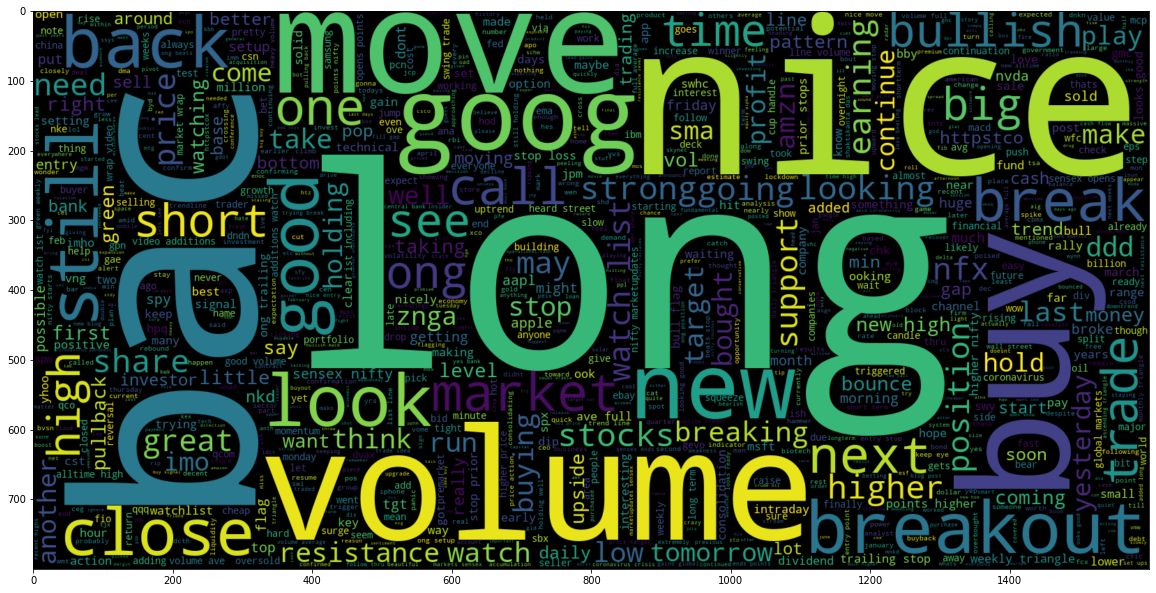

In [16]:
# Plot the word cloud with positive sentiment
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(stock_df[stock_df['Sentiment'] == 1]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

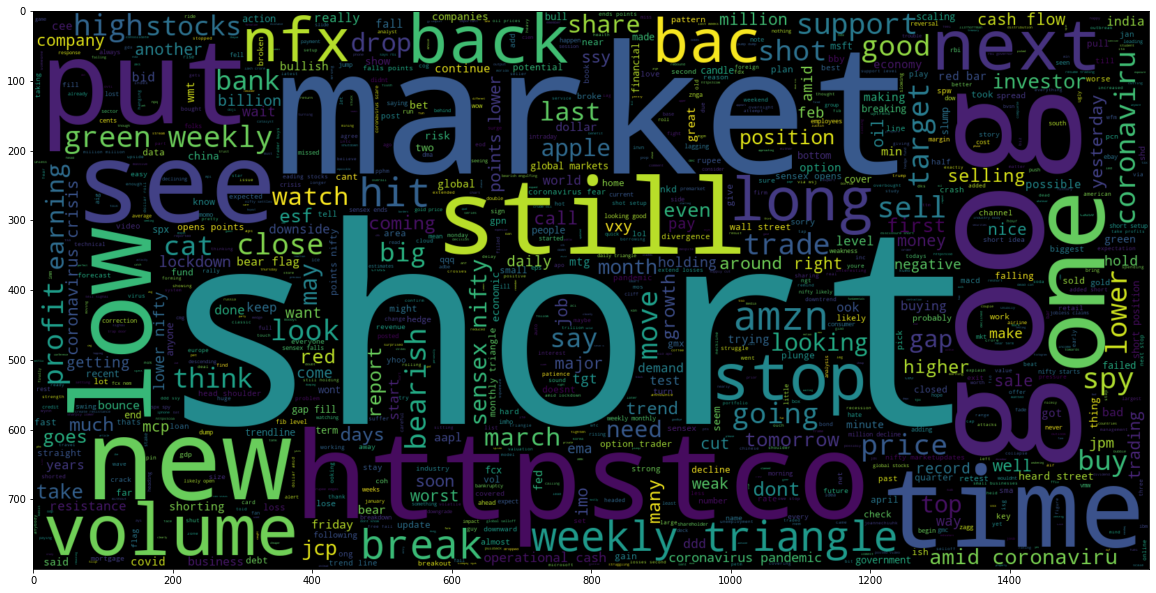

In [17]:
# Plot the word cloud with negative sentiment
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(stock_df[stock_df['Sentiment'] == 0]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

**Clean dataset visuals**

In [18]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
# word_tokenize
print(stock_df['Text Without Punc & Stopwords Joined'][0])
print(nltk.word_tokenize(stock_df['Text Without Punc & Stopwords Joined'][0]))

kickers watchlist xide tit soq pnk cpw bpz trade method method see prev posts
['kickers', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'trade', 'method', 'method', 'see', 'prev', 'posts']


In [20]:
# Get the maximum length of data
maxlen = -1
for doc in stock_df['Text Without Punc & Stopwords Joined']:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is:", maxlen)

The maximum number of words in any document is: 20


In [21]:
tweets_length = [ len(nltk.word_tokenize(x)) for x in stock_df['Text Without Punc & Stopwords Joined'] ]
tweets_length

[14,
 6,
 7,
 1,
 0,
 1,
 8,
 13,
 8,
 4,
 10,
 18,
 8,
 8,
 11,
 5,
 12,
 10,
 12,
 4,
 6,
 5,
 2,
 5,
 3,
 10,
 3,
 3,
 9,
 6,
 8,
 10,
 8,
 3,
 10,
 11,
 4,
 8,
 11,
 10,
 10,
 7,
 9,
 8,
 4,
 10,
 8,
 7,
 7,
 9,
 10,
 10,
 8,
 2,
 14,
 12,
 9,
 8,
 1,
 14,
 7,
 11,
 5,
 13,
 6,
 6,
 7,
 6,
 6,
 10,
 9,
 4,
 10,
 13,
 16,
 6,
 9,
 6,
 2,
 11,
 5,
 4,
 9,
 11,
 16,
 4,
 9,
 5,
 6,
 2,
 1,
 5,
 9,
 4,
 7,
 6,
 7,
 10,
 1,
 3,
 9,
 4,
 16,
 8,
 10,
 11,
 18,
 6,
 7,
 13,
 12,
 9,
 3,
 3,
 10,
 10,
 8,
 6,
 8,
 5,
 5,
 8,
 9,
 15,
 3,
 5,
 9,
 18,
 13,
 11,
 3,
 1,
 1,
 2,
 7,
 12,
 12,
 8,
 8,
 10,
 9,
 10,
 15,
 8,
 9,
 9,
 12,
 10,
 6,
 10,
 13,
 4,
 11,
 8,
 15,
 13,
 8,
 12,
 5,
 5,
 3,
 7,
 2,
 4,
 10,
 5,
 6,
 10,
 6,
 16,
 9,
 6,
 5,
 10,
 9,
 10,
 8,
 2,
 10,
 9,
 10,
 12,
 7,
 10,
 7,
 3,
 6,
 5,
 9,
 9,
 4,
 6,
 5,
 4,
 4,
 8,
 10,
 8,
 8,
 13,
 9,
 7,
 10,
 12,
 8,
 6,
 5,
 3,
 10,
 11,
 6,
 9,
 10,
 13,
 10,
 7,
 12,
 7,
 11,
 10,
 4,
 4,
 3,
 10,
 2,
 9,
 10,
 15,
 12,
 10

In [22]:
# Plot distribution for the number of words in a text
fig = px.histogram(x = tweets_length, nbins = 50)
fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



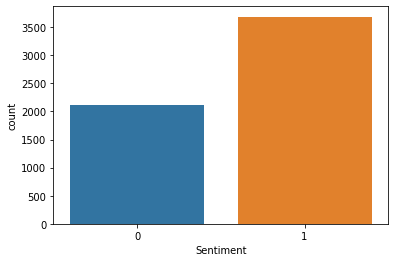

In [25]:
# Plot sentiment
# 0 = Negative 1 = Possitive 
sns.countplot(stock_df['Sentiment'])

**Tokenizer**

In [26]:
# Total words in dataset
list_of_words = []
for i in stock_df['Text Without Punc & Stopwords']:
    for j in i:
        list_of_words.append(j)


In [27]:
list_of_words

['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'trade',
 'method',
 'method',
 'see',
 'prev',
 'posts',
 'movie',
 'return',
 'feageed',
 'indicator',
 'trades',
 'awesome',
 'afraid',
 'short',
 'amzn',
 'looking',
 'like',
 'nearmonopoly',
 'ebooks',
 'mnta',
 'pgnx',
 'current',
 'downtrend',
 'break',
 'otherwise',
 'shortterm',
 'correction',
 'medterm',
 'downtrend',
 'mondays',
 'relative',
 'weakness',
 'nyx',
 'win',
 'tie',
 'tap',
 'ice',
 'int',
 'bmc',
 'aon',
 'chk',
 'biib',
 'goog',
 'ower',
 'trend',
 'line',
 'channel',
 'test',
 'volume',
 'support',
 'watch',
 'tomorrow',
 'ong',
 'entry',
 'assuming',
 'fcx',
 'opens',
 'tomorrow',
 'trigger',
 'buy',
 'still',
 'much',
 'like',
 'setup',
 'really',
 'worries',
 'everyone',
 'expects',
 'market',
 'rally',
 'nowusually',
 'exact',
 'opposite',
 'happens',
 'every',
 'time',
 'shall',
 'see',
 'soon',
 'bac',
 'spx',
 'jpm',
 'gamcos',
 'arry',
 'haverty',
 'apple',
 'extremely',
 'chea

In [29]:
# Unique words
total_words = len(list(set(list_of_words)))
total_words

9268

In [31]:
# Split the dataset
X = stock_df['Text Without Punc & Stopwords']
y = stock_df['Sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [32]:
X_train.shape

(5211,)

In [33]:
X_test.shape

(580,)

In [34]:
X_train

5111    [sharp, drop, fuel, consumption, caused, coron...
980                                  [schw, breaks, flag]
5650    [sensex, closes, points, higher, nifty, market...
483                                   [mgm, caught, ange]
4967    [happy, easter, shot, setups, isg, nkd, moh, mtz]
                              ...                        
5228    [new, billion, paycheck, protection, program, ...
880     [goog, amzn, calls, watch, list, trade, taking...
5238    [allstate, said, would, dispatch, million, she...
4492    [vhc, breaks, support, level, could, bring, ar...
1419    [zqk, first, sign, decreasing, volume, minute,...
Name: Text Without Punc & Stopwords, Length: 5211, dtype: object

In [35]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)

# Training data
train_sequences = tokenizer.texts_to_sequences(X_train)

# Testing data
test_sequences = tokenizer.texts_to_sequences(X_test)


In [36]:
train_sequences

[[2465, 204, 1890, 3624, 1891, 19, 205, 3625, 3626, 1112, 44, 3627],
 [965, 192, 90],
 [24, 485, 48, 17, 29, 53, 652, 288, 365, 26, 653, 149, 3628],
 [561, 966, 1520],
 [697, 3629, 125, 562, 967, 137, 3630, 2466],
 [113, 563, 1892, 126, 1113],
 [24, 29, 164, 144, 856, 1293, 51, 1893, 366, 3631, 3632],
 [1894, 165],
 [857, 105, 1895, 106, 60, 858, 458, 698, 339, 32, 217, 39],
 [968, 3633, 155, 3634, 859, 1521, 340, 28, 1294, 3635, 1522, 172],
 [3636, 193, 16, 32, 55],
 [486, 1295, 17, 255, 1296, 3637],
 [777, 60, 289, 104],
 [9, 12, 459],
 [523, 1896],
 [434, 84, 3638, 33, 1523, 42],
 [10, 269, 7, 1522],
 [1897, 12, 43, 37, 1297, 256, 1298, 8, 194],
 [859, 1524, 778, 114, 3639, 56, 150, 20, 860, 460, 3640, 435, 699, 24],
 [213,
  115,
  2467,
  1299,
  2467,
  1898,
  316,
  487,
  2468,
  3641,
  1525,
  367,
  3642,
  861],
 [779, 2469, 116, 524, 34, 969],
 [22, 700],
 [701, 100, 16, 68, 32, 461, 1899, 173, 462, 107],
 [368, 3643, 94, 461, 105, 3644, 368],
 [970, 115, 3645, 214, 1526,

In [37]:
test_sequences

[[31, 23, 22],
 [131, 137, 70, 412, 422, 150, 790, 76, 291, 473],
 [2613, 833, 392, 240, 17, 1358, 1779, 781, 2314],
 [120, 2323, 1935],
 [28, 624, 116, 172, 341, 270, 343, 76, 291, 633],
 [75, 232, 389, 136, 64, 2, 22, 148],
 [807, 195, 1209, 16, 290, 195, 12, 4983, 195, 12, 121, 77, 170, 78, 15, 621],
 [713, 1441, 15, 60, 289, 412, 1652],
 [206, 512, 7, 441, 687, 2364, 1196, 339, 8046],
 [31, 1497, 1108, 226, 774, 421, 825, 367, 296, 1926],
 [2262, 1232, 211],
 [42, 636, 22, 552, 8, 191],
 [7385, 1552, 1553, 6, 392, 534, 26, 5, 1554, 20, 64],
 [268, 1266, 219, 187, 1046, 187, 30, 363, 769, 35],
 [904, 1510, 2366, 2011, 371, 93, 343, 76, 291, 372, 2130, 1510, 2366, 2011],
 [689, 1052, 123, 1064, 1466, 3563, 7, 707, 45],
 [1460, 5, 1, 280, 2209, 4, 3519, 75],
 [1229, 1119, 117, 3907],
 [458, 341, 1193, 409, 97, 8582, 423, 6930, 2561],
 [485, 437, 182, 98, 14, 964, 85],
 [86, 3412, 116, 100, 51, 330, 634, 100, 51, 330],
 [24, 29, 164, 122, 17, 288, 398, 44],
 [9, 41, 471, 2, 8396, 2214,

In [38]:
print("The encoding for document\n", X_train[1:2],"\n is: ", train_sequences[1])

The encoding for document
 980    [schw, breaks, flag]
Name: Text Without Punc & Stopwords, dtype: object 
 is:  [965, 192, 90]


In [39]:
# Add padding to training and testing
padded_train = pad_sequences(train_sequences, maxlen = 29, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 29, truncating = 'post')

In [40]:
for i, doc in enumerate(padded_train[:3]):
     print("The padded encoding for document:", i+1," is:", doc)

The padded encoding for document: 1  is: [2465  204 1890 3624 1891   19  205 3625 3626 1112   44 3627    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
The padded encoding for document: 2  is: [965 192  90   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]
The padded encoding for document: 3  is: [  24  485   48   17   29   53  652  288  365   26  653  149 3628    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [41]:
# Convert the data to categorical 2D representation
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [42]:
y_train_cat.shape

(5211, 2)

In [43]:
y_test_cat.shape

(580, 2)

In [44]:
y_train_cat

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

**Deep learning model**

In [47]:
# Sequential Model
model = Sequential()

# Embedding layer
model.add(Embedding(total_words, output_dim = 512))

# Bi-Directional RNN and LSTM
model.add(LSTM(256))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 512)         4745216   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 5,565,826
Trainable params: 5,565,826
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Train the model
model.fit(padded_train, y_train_cat, batch_size = 32, validation_split = 0.2, epochs = 2)

Epoch 1/2
131/131 [==============================] - 42s 303ms/step - loss: 0.6676 - acc: 0.6176 - val_loss: 0.6578 - val_acc: 0.6443
Epoch 2/2
131/131 [==============================] - 39s 296ms/step - loss: 0.6492 - acc: 0.6486 - val_loss: 0.5467 - val_acc: 0.7287


**Predictions**

In [48]:
pred = model.predict(padded_test)

In [49]:
prediction = []
for i in pred:
  prediction.append(np.argmax(i))

In [50]:
# List containing original values
original = []
for i in y_test_cat:
  original.append(np.argmax(i))

In [51]:
# Acuracy score on text data
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, prediction)
accuracy

0.5

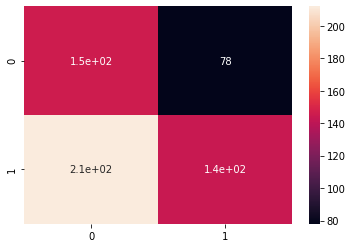

In [52]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot = True)